In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/malayakew-plant-leaf-dataset/MK/readMe.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/name_of_spesies.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R225_00163.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R45_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(6)R90_00108.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(5)R225_00097.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R315_00162.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(4)R180_00074.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R180_00141.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(3)R225_00050.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/te

**Import library**

In [142]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from zipfile import ZipFile
import os,glob
import cv2

**load images**

In [143]:
def load_images(root_folder, folder_names, target_size=(128, 128)):
    X = []  # Image data
    Y = []  # Corresponding labels
    
    label_counter = 0  
    
    for folder_name in folder_names:
        folder_path = os.path.join(root_folder, folder_name)
        
        if os.path.isdir(folder_path):
            for filename in sorted(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, filename)
                
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized)
                    
                    X.append(img_array)
                    Y.append(label_counter)

            label_counter += 1
    
    return np.array(X), np.array(Y)

In [144]:
dataset_train = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/train'
dataset_test = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/test'

In [145]:
selected_folders_different = ['Class (4)', 'Class (8)']  
X_train_different, Y_train_different = load_images(dataset_train, selected_folders_different)
X_test_different, Y_test_different = load_images(dataset_test, selected_folders_different)

In [146]:
print("X_train_different", X_train_different.shape)
print("Y_train_different", Y_train_different.shape)
print("X_test_different", X_test_different.shape)
print("Y_test_different", Y_test_different.shape)

X_train_different (104, 128, 128, 3)
Y_train_different (104,)
X_test_different (24, 128, 128, 3)
Y_test_different (24,)


In [147]:
selected_folders_similar = ['Class (38)', 'Class (39)']
X_train_similar, Y_train_similar = load_images(dataset_train, selected_folders_similar)
X_test_similar, Y_test_similar = load_images(dataset_test, selected_folders_similar)

In [148]:
print("X_train_similar", X_train_similar.shape)
print("Y_train_similar", Y_train_similar.shape)
print("X_test_similar", X_test_similar.shape)
print("Y_test_similar", Y_test_similar.shape)

X_train_similar (104, 128, 128, 3)
Y_train_similar (104,)
X_test_similar (24, 128, 128, 3)
Y_test_similar (24,)


**Normalize Data**

In [149]:
X_train_different = np.array(X_train_different)
Y_train_different = np.array(Y_train_different)
X_test_different = np.array(X_test_different)
Y_test_different = np.array(Y_test_different)

X_train_different = X_train_different.astype('float32') / 255.0
X_test_different = X_test_different.astype('float32') / 255.0

In [150]:
X_train_similar = X_train_similar.astype('float32') / 255.0
X_test_similar = X_test_similar.astype('float32') / 255.0

X_train_similar = np.array(X_train_similar)
Y_train_similar = np.array(Y_train_similar)
X_test_similar = np.array(X_test_similar)
Y_test_similar = np.array(Y_test_similar)

**Image augmentation**

In [151]:
data_generator = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=50,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0) 
        for _ in range(5):
            seed = np.random.randint(0, 1000)
            for batch in data_generator.flow(img, batch_size=1, seed=seed):
                augmented_data.append((np.squeeze(batch)))
                break
    return np.array(augmented_data)

In [152]:
X_train_different_augmented = augment_dataset(X_train_different)
Y_train_different_augmented = np.repeat(Y_train_different,5, axis=0)

X_test_different_augmented = augment_dataset(X_test_different)
Y_test_different_augmented = np.repeat(Y_test_different,5, axis=0)

In [153]:
print("X_train_different_augmented", X_train_different_augmented.shape)
print("Y_train_different_augmented", Y_train_different_augmented.shape)
print("X_test_different_augmented", X_test_different_augmented.shape)
print("Y_test_different_augmented", Y_test_different_augmented.shape)

X_train_different_augmented (520, 128, 128, 3)
Y_train_different_augmented (520,)
X_test_different_augmented (120, 128, 128, 3)
Y_test_different_augmented (120,)


In [154]:
X_train_similar_augmented = augment_dataset(X_train_similar)
Y_train_similar_augmented = np.repeat(Y_train_similar,5, axis=0)

X_test_similar_augmented = augment_dataset(X_test_similar)
Y_test_similar_augmented = np.repeat(Y_test_similar,5, axis=0)

In [116]:
print("X_train_similar_augmented", X_train_similar_augmented.shape)
print("Y_train_similar_augmented", Y_train_similar_augmented.shape)
print("X_test_similar_augmented", X_test_similar_augmented.shape)
print("Y_test_similar_augmented", Y_test_similar_augmented.shape)

X_train_similar_augmented (520, 128, 128, 3)
Y_train_similar_augmented (520,)
X_test_similar_augmented (120, 128, 128, 3)
Y_test_similar_augmented (120,)


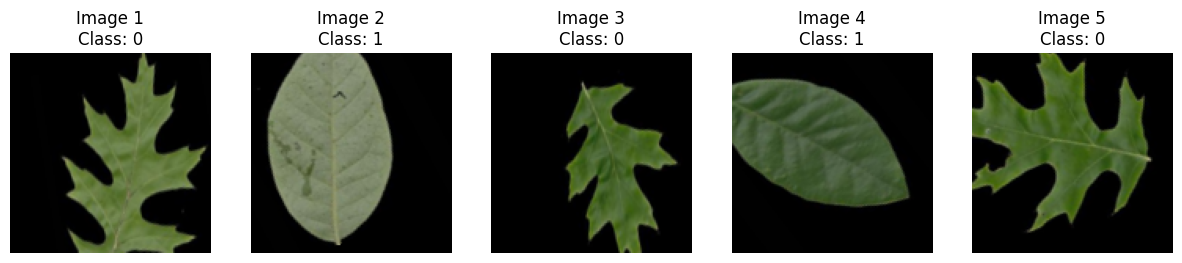

In [155]:
# Class (4) & Class (8) 
indices = np.random.randint(0, len(X_train_different_augmented), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5)) 
for i, index in enumerate(indices):
    axes[i].imshow(X_train_different_augmented[index])
    axes[i].axis('off')  # Turn off axis labels
    class_label = Y_train_different_augmented[index] 
    axes[i].set_title(f"Image {i+1}\nClass: {class_label}")

plt.show()

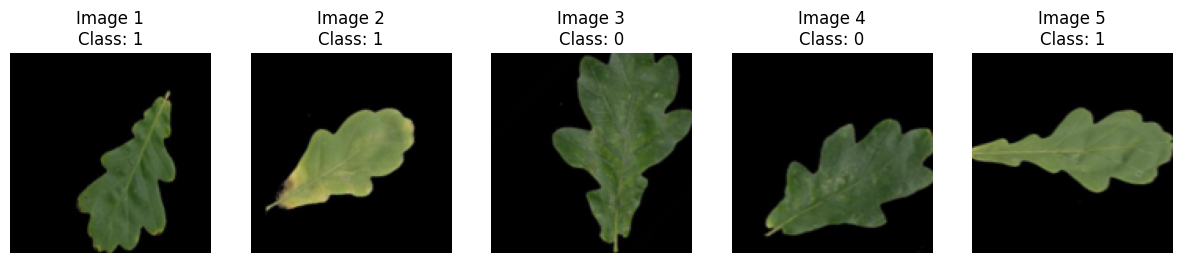

In [156]:
# Class (38) & Class (39) 
indices = np.random.randint(0, len(X_train_similar_augmented), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5)) 

for i, index in enumerate(indices):
    axes[i].imshow(X_train_similar_augmented[index])
    axes[i].axis('off')  # Turn off axis labels
    class_label = Y_train_similar_augmented[index]
    axes[i].set_title(f"Image {i+1}\nClass: {class_label}")

plt.show()

In [157]:
# Combine original data with augmented data
X_train_different_combined = np.concatenate((X_train_different, X_train_different_augmented))
Y_train_different_combined = np.concatenate((Y_train_different, Y_train_different_augmented))

X_test_different_combined = np.concatenate((X_test_different, X_test_different_augmented))
Y_test_different_combined = np.concatenate((Y_test_different, Y_test_different_augmented))

# Shuffle the combined data
X_train_different_combined, Y_train_different_combined = shuffle(X_train_different_combined, Y_train_different_combined, random_state=42)
X_test_different_combined, Y_test_different_combined = shuffle(X_test_different_combined, Y_test_different_combined, random_state=42)

In [158]:
print("X_train_different_combined", X_train_different_combined.shape)
print("Y_train_different_combined", Y_train_different_combined.shape)
print("X_test_different_combined", X_test_different_combined.shape)
print("Y_test_different_combined", Y_test_different_combined.shape)

X_train_different_combined (624, 128, 128, 3)
Y_train_different_combined (624,)
X_test_different_combined (144, 128, 128, 3)
Y_test_different_combined (144,)


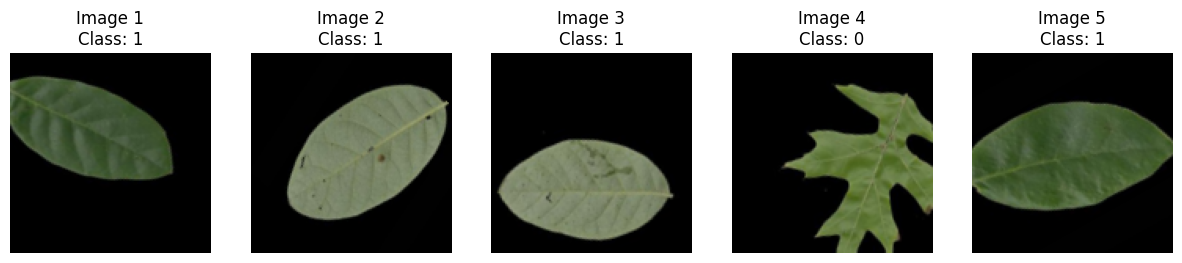

In [159]:
# Class (4) & Class (8) 
indices = np.random.randint(0, len(X_train_different_augmented), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5)) 

for i, index in enumerate(indices):
    axes[i].imshow(X_train_different_augmented[index])
    axes[i].axis('off') 
    class_label = Y_train_different_augmented[index]  
    axes[i].set_title(f"Image {i+1}\nClass: {class_label}")

plt.show()

In [161]:
# Combine original data with augmented data
X_train_similar_combined = np.concatenate((X_train_similar, X_train_similar_augmented))
Y_train_similar_combined = np.concatenate((Y_train_similar, Y_train_similar_augmented))

X_test_similar_combined = np.concatenate((X_test_similar, X_test_similar_augmented))
Y_test_similar_combined = np.concatenate((Y_test_similar, Y_test_similar_augmented))

# Shuffle the combined data
X_train_similar_combined, Y_train_similart_combined = shuffle(X_train_similar_combined, Y_train_similar_combined, random_state=42)
X_test_similar_combined, Y_test_similar_combined = shuffle(X_test_similar_combined, Y_test_similar_combined, random_state=42)

In [162]:
print("X_train_similar_combined", X_train_similar_combined.shape)
print("Y_train_similar_combined", Y_train_similar_combined.shape)
print("X_test_similar_combined", X_test_similar_combined.shape)
print("Y_test_similar_combined", Y_test_similar_combined.shape)

X_train_similar_combined (624, 128, 128, 3)
Y_train_similar_combined (624,)
X_test_similar_combined (144, 128, 128, 3)
Y_test_similar_combined (144,)


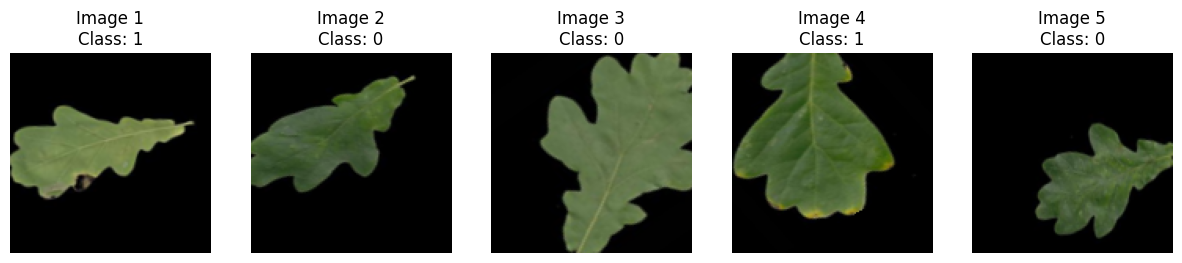

In [125]:
# Class (38) & Class (39) 
indices = np.random.randint(0, len(X_train_similar_augmented), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))  
for i, index in enumerate(indices):
    axes[i].imshow(X_train_similar_augmented[index])
    axes[i].axis('off') 
    class_label = Y_train_similar_augmented[index]  
    axes[i].set_title(f"Image {i+1}\nClass: {class_label}")

plt.show()

# Pret_Trained models on Class 4 & Class 8

#  Xception Model

In [88]:
from tensorflow.keras.applications import xception
from tensorflow.keras import regularizers

def build_model(hp):
    base_model = xception.Xception(weights='/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the pre-trained Xception
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    model = keras.Sequential()

    # Add the pre-trained Xception model
    model.add(base_model)

    # Flatten the output of Xception
    model.add(keras.layers.GlobalAveragePooling2D())

    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_units3 = hp.Int('units', min_value=32, max_value=128, step=16)


    model.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.F1Score(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=metrics)

    return build_model

# MobileNet Model

In [129]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers

def build_model2(hp):
    # Load pre-trained MobileNet model
    base = MobileNet(weights='/kaggle/input/mobilenet/mobilenet_1_0_128_tf_no_top.h5', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the pre-trained MobileNet except the last three layers
    for layer in base.layers[:-5]:
        layer.trainable = False

    for layer in base.layers[-5:]:
        layer.trainable = True

    build_model2 = keras.Sequential()

    # Add the pre-trained MobileNet model
    build_model2.add(base)

    # Flatten the output of MobileNet
    build_model2.add(keras.layers.GlobalAveragePooling2D())

    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=16)

    build_model2.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model2.add(layers.Dropout(0.5))
    build_model2.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model2.add(layers.Dropout(0.4))
    build_model2.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model2.add(layers.Dropout(0.3))
    build_model2.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model2.add(layers.Dropout(0.5))
    build_model2.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model2.add(layers.Dropout(0.5))
    build_model2.add(layers.Dense(units=hp_units3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

    # Output layer
    build_model2.add(layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    metrics = [
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.F1Score(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]


    # Compile the model
    build_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                         loss='binary_crossentropy',
                         metrics=metrics)

    return build_model2

In [89]:
!pip install -U keras-tuner

In [130]:
# Mobilene model
import kerastuner as kt
objective = kt.Objective(
name="val_accuracy",
direction="max")

tuner=kt.Hyperband(build_model2,
                  objective=objective,
                  max_epochs=15,
                  factor=5)

In [131]:
# Mobilene model
import tensorflow as tf
from tensorflow.keras import callbacks
from IPython.display import clear_output

class ClearTrainingOutput(callbacks.Callback):
    def on_train_end(self, *args, **kwargs):
        clear_output(wait=True)

In [132]:
# Mobilene model
tuner.search(X_train_different_combined,Y_train_different_combined.astype('float32'),epochs=10,validation_split=0.2,callbacks=[ClearTrainingOutput()])
best_hyperparameters_different_MobileNet_model = tuner.get_best_hyperparameters(num_trials=1)[0]
MobileNet_model_different =tuner.hypermodel.build(best_hyperparameters_different_MobileNet_model)
tuner.search_space_summary()

Trial 13 Complete [00h 01m 18s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 35s
Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [133]:
# Mobilene model
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]

history_different_build_model2=MobileNet_model_different.fit(X_train_different_combined,Y_train_different_combined.astype('float32'),epochs=30,validation_split=0.2,callbacks=callbacks)

Epoch 1/30
16/16 [==============================] - 9s 351ms/step - loss: 11.8041 - accuracy: 0.8076 - recall_1: 0.8066 - precision_1: 0.8000 - f1_score: 0.7320 - false_negatives_1: 47.0000 - false_positives_1: 49.0000 - true_negatives_1: 207.0000 - true_positives_1: 196.0000 - val_loss: 8.1901 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_f1_score: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 56.0000 - val_true_positives_1: 69.0000
Epoch 2/30
16/16 [==============================] - 5s 287ms/step - loss: 6.4475 - accuracy: 0.9840 - recall_1: 0.9794 - precision_1: 0.9876 - f1_score: 0.9586 - false_negatives_1: 5.0000 - false_positives_1: 3.0000 - true_negatives_1: 253.0000 - true_positives_1: 238.0000 - val_loss: 4.6288 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_f1_score: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_true_ne

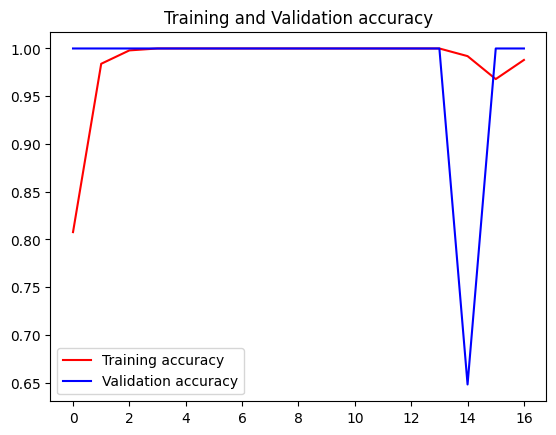

<Figure size 640x480 with 0 Axes>

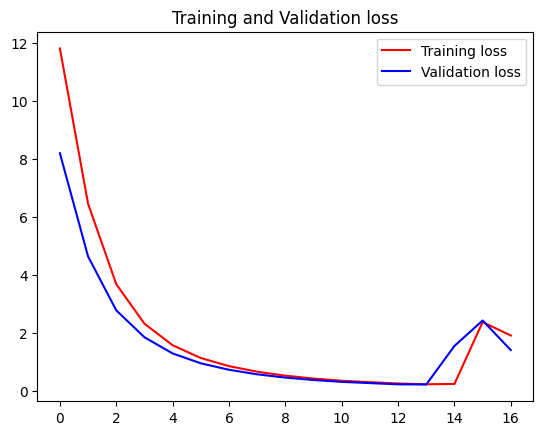

<Figure size 640x480 with 0 Axes>

In [134]:
# Mobilene model
acc = history_different_build_model2.history['accuracy']
val_acc= history_different_build_model2.history['val_accuracy']
loss = history_different_build_model2.history['loss']
val_loss = history_different_build_model2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [135]:
# Mobilene model
MobileNet_model_different.evaluate(X_train_different_augmented,Y_train_different_augmented.astype('float32'))

17/17 [==============================] - 3s 166ms/step - loss: 1.3986 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000 - f1_score: 0.9028 - false_negatives_1: 0.0000e+00 - false_positives_1: 0.0000e+00 - true_negatives_1: 260.0000 - true_positives_1: 260.0000


[1.3986225128173828,
 1.0,
 1.0,
 1.0,
 array([0.90277773], dtype=float32),
 0.0,
 0.0,
 260.0,
 260.0]

In [91]:
# Xception model
import kerastuner as kt
objective = kt.Objective(
name="val_accuracy",
direction="max")

tuner=kt.Hyperband(build_model,
                  objective=objective,
                  max_epochs=15,
                  factor=5)

In [93]:
# Xception model
import tensorflow as tf
from tensorflow.keras import callbacks
from IPython.display import clear_output

class ClearTrainingOutput(callbacks.Callback):
    def on_train_end(self, *args, **kwargs):
        clear_output(wait=True)

In [95]:
# Xception model
tuner.search(X_train_different_combined,Y_train_different_combined.astype('float32'),epochs=10,validation_split=0.2,callbacks=[ClearTrainingOutput()])
best_hps_different=tuner.get_best_hyperparameters(num_trials=1)[0]
model_different =tuner.hypermodel.build(best_hps_different)
tuner.search_space_summary()

Trial 13 Complete [00h 05m 35s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 37m 13s
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [96]:
# Xception model
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]

history_different_build_model=model_different.fit(X_train_different_combined,Y_train_different_combined.astype('float32'),epochs=30,validation_split=0.2,callbacks=callbacks)

Epoch 1/30
16/16 [==============================] - 27s 1s/step - loss: 18.1847 - accuracy: 0.7234 - recall_1: 0.9218 - precision_1: 0.6531 - f1_score: 0.6550 - false_negatives_1: 19.0000 - false_positives_1: 119.0000 - true_negatives_1: 137.0000 - true_positives_1: 224.0000 - val_loss: 13.6798 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_f1_score: 0.7113 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 56.0000 - val_true_positives_1: 69.0000
Epoch 2/30
16/16 [==============================] - 21s 1s/step - loss: 10.9136 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000 - f1_score: 0.6612 - false_negatives_1: 0.0000e+00 - false_positives_1: 0.0000e+00 - true_negatives_1: 256.0000 - true_positives_1: 243.0000 - val_loss: 8.0168 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_f1_score: 0.8571 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_

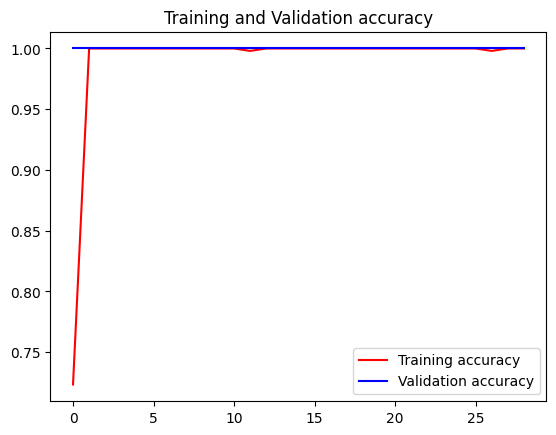

<Figure size 640x480 with 0 Axes>

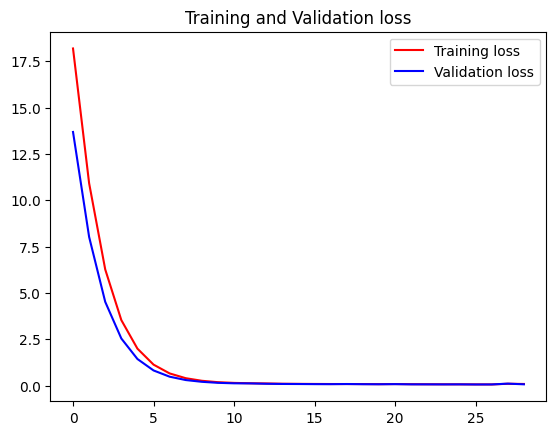

<Figure size 640x480 with 0 Axes>

In [97]:
# Xception model
acc = history_different_build_model.history['accuracy']
val_acc= history_different_build_model.history['val_accuracy']
loss = history_different_build_model.history['loss']
val_loss = history_different_build_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [98]:
# Xception model
model_different.evaluate(X_train_different_augmented,Y_train_different_augmented.astype('float32'))

17/17 [==============================] - 15s 903ms/step - loss: 0.0658 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000 - f1_score: 0.6667 - false_negatives_1: 0.0000e+00 - false_positives_1: 0.0000e+00 - true_negatives_1: 260.0000 - true_positives_1: 260.0000


[0.0658041313290596,
 1.0,
 1.0,
 1.0,
 array([0.6666667], dtype=float32),
 0.0,
 0.0,
 260.0,
 260.0]

5/5 [==============================] - 4s 804ms/step


Text(0.5, 1.0, 'Confusion Matrix for Xception')

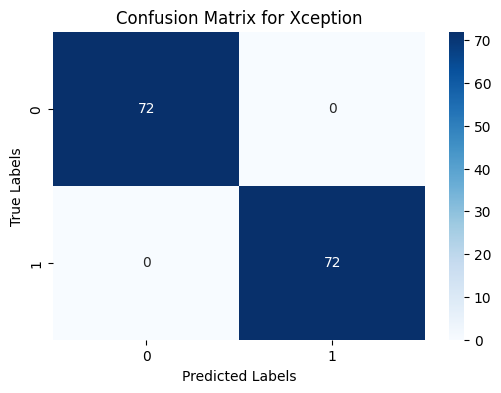

In [101]:
# Xception model
pred1 = model_different.predict(X_test_different_combined)
# Compute confusion matrix
conf_matrix_Xception = confusion_matrix(Y_test_different_combined, np.where(pred1 >= 0.5, 1, 0))


# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_Xception, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Pre_Trained model for Class 38 & Class 39

#  Xception Model

In [172]:
from tensorflow.keras.applications import xception
from tensorflow.keras import regularizers

def build_model_similar(hp):
    # Load pre-trained Xception model
    base_model = xception.Xception(weights='/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the pre-trained Xception
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    build_model_similar = keras.Sequential()

    # Add the pre-trained Xception model
    build_model_similar.add(base_model)

    # Flatten the output of Xception
    build_model_similar.add(keras.layers.GlobalAveragePooling2D())

    hp_units1_similar = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2_similar = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_units3_similar = hp.Int('units', min_value=32, max_value=128, step=16)


    build_model_similar.add(layers.Dense(units=hp_units1_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
    build_model_similar.add(layers.Dropout(0.5))
    build_model_similar.add(layers.Dense(units=hp_units1_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model_similar.add(layers.Dropout(0.4))
    build_model_similar.add(layers.Dense(units=hp_units2_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model_similar.add(layers.Dropout(0.3))
    build_model_similar.add(layers.Dense(units=hp_units2_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model_similar.add(layers.Dropout(0.5))
    build_model_similar.add(layers.Dense(units=hp_units2_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    build_model_similar.add(layers.Dropout(0.5))
    build_model_similar.add(layers.Dense(units=hp_units3_similar, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    build_model_similar.add(layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.F1Score(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]

    # Compile the model
    build_model_similar.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=metrics)

    return build_model_similar

In [173]:
# Xception model_similar
import kerastuner as kt
objective = kt.Objective(
name="val_accuracy",
direction="max")

tuner=kt.Hyperband(build_model_similar,
                  objective=objective,
                  max_epochs=15,
                  factor=5)

In [174]:
# Xception model_similar
import tensorflow as tf
from tensorflow.keras import callbacks
from IPython.display import clear_output

class ClearTrainingOutput(callbacks.Callback):
    def on_train_end(self, *args, **kwargs):
        clear_output(wait=True)

In [175]:
# Xception model_similar
tuner.search(X_train_similar_combined,Y_train_similar_combined.astype('float32'),epochs=10,validation_split=0.2,callbacks=[ClearTrainingOutput()])
best_hps_similar=tuner.get_best_hyperparameters(num_trials=1)[0]
model_similar =tuner.hypermodel.build(best_hps_similar)
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [176]:
# Xception model_similar
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)]

history_similar_build_model=model_similar.fit(X_train_similar_combined,Y_train_similar_combined.astype('float32'),epochs=30,validation_split=0.2,callbacks=callbacks)

Epoch 1/30
16/16 [==============================] - 27s 1s/step - loss: 2.3691 - accuracy: 0.5711 - recall_4: 0.2620 - precision_4: 0.3920 - f1_score: 0.5452 - false_negatives_4: 138.0000 - false_positives_4: 76.0000 - true_negatives_4: 236.0000 - true_positives_4: 49.0000 - val_loss: 1.8605 - val_accuracy: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_f1_score: 1.0000 - val_false_negatives_4: 125.0000 - val_false_positives_4: 0.0000e+00 - val_true_negatives_4: 0.0000e+00 - val_true_positives_4: 0.0000e+00
Epoch 2/30
16/16 [==============================] - 20s 1s/step - loss: 1.4797 - accuracy: 0.6212 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - f1_score: 0.5452 - false_negatives_4: 187.0000 - false_positives_4: 2.0000 - true_negatives_4: 310.0000 - true_positives_4: 0.0000e+00 - val_loss: 1.7172 - val_accuracy: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_f1_score: 1.0000 - val_false_negatives_4: 125.0000 - val_false_posi

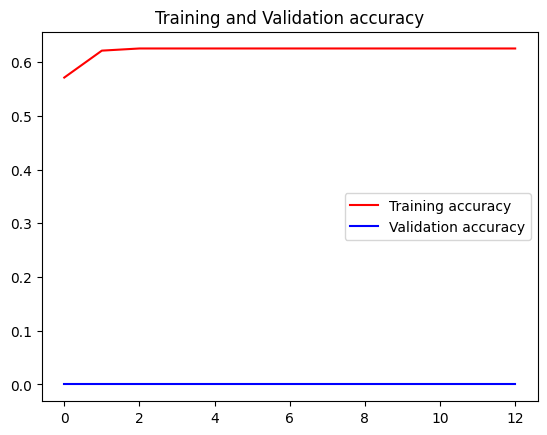

<Figure size 640x480 with 0 Axes>

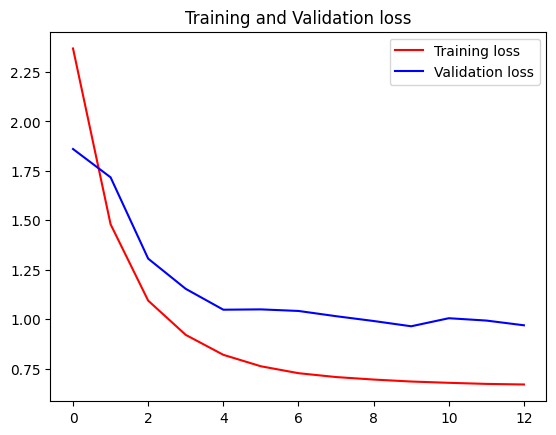

<Figure size 640x480 with 0 Axes>

In [177]:
# Xception model
acc = history_similar_build_model.history['accuracy']
val_acc= history_similar_build_model.history['val_accuracy']
loss = history_similar_build_model.history['loss']
val_loss = history_similar_build_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [178]:
# Xception model_similar
model_similar.evaluate(X_train_similar_augmented,Y_train_similar_augmented.astype('float32'))

17/17 [==============================] - 15s 874ms/step - loss: 0.7281 - accuracy: 0.5000 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - f1_score: 0.6667 - false_negatives_4: 260.0000 - false_positives_4: 0.0000e+00 - true_negatives_4: 260.0000 - true_positives_4: 0.0000e+00


[0.7281310558319092,
 0.5,
 0.0,
 0.0,
 array([0.6666667], dtype=float32),
 260.0,
 0.0,
 260.0,
 0.0]